<a href="https://colab.research.google.com/github/juhumkwon/DeepLearning/blob/main/CL_08_04_rnn_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Columns in AAPL: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
all_data.head(10)=             Close   Open   High    Low     Volume
Date                                             
2017-01-03  26.80  26.72  26.84  26.48  115127600
2017-01-04  26.77  26.73  26.88  26.70   84472400
2017-01-05  26.90  26.74  26.96  26.72   88774400
2017-01-06  27.20  26.94  27.26  26.87  127007600
2017-01-09  27.45  27.21  27.55  27.21  134247600
2017-01-10  27.48  27.40  27.54  27.29   97848400
2017-01-11  27.63  27.39  27.67  27.36  110354400
2017-01-12  27.51  27.43  27.52  27.27  108344800
2017-01-13  27.46  27.48  27.60  27.41  104447600
2017-01-17  27.69  27.30  27.74  27.27  137759200
Epoch 1/10


/tmp/ipython-input-1487828153.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  AAPL = yf.download('AAPL',
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0166
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 7.9899e-04
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.8547e-04
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 2.4277e-04
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.1062e-04
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 2.1361e-04
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 2.2408e-04
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 2.2182e-04
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 2.4174e-04
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.0695e-04
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


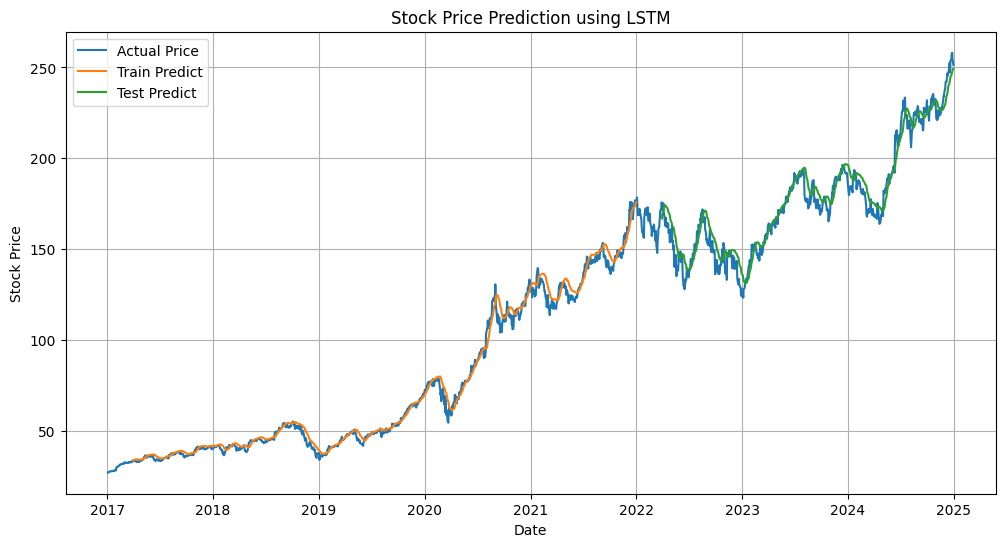

In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


AAPL = yf.download('AAPL',
                  start = '2017-01-01',
                  end = '2024-12-31',
                  progress = False)

# 수정종가(Adj close), 시가(Open), 최고가(High), 최저가(Low), 종가(Close). 거래량(Volume)
# Check the actual column names in AAPL
print("Columns in AAPL:", AAPL.columns)
all_data = AAPL[[('Close', 'AAPL'), ('Open', 'AAPL'), ('High', 'AAPL'),('Low', 'AAPL'),('Volume', 'AAPL')]].round(2)
all_data.columns = ['Close', 'Open', 'High', 'Low', 'Volume'] # Simplify column names
all_data.head(10)
print("all_data.head(10)=", all_data.head(10))

"""
참고자료 : 2017년까지의 데이터, 2024년 이후의 데이터, 수정종가 그래프
print("There are "+str(all_data[:'2017'].shape[0])+" observations in the training data")
print("There are "+str(all_data['2024':].shape[0])+" observations in the test data")
all_data['Adj Close'].plot()
"""
data = all_data[['Close']]  # 종가 데이터만 사용


# 2. 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))  # 데이터 정규화
scaled_data = scaler.fit_transform(data)

# Use integer-based indexing for splitting scaled_data based on the date boundary
train_data_len = len(data[:'2021'])
train_data = scaled_data[:train_data_len]
test_data = scaled_data[train_data_len:]


# LSTM 입력 형식으로 데이터 준비
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0]) # x의 0번째 열에서 i 번째 행부터 i + time_step째 행까지의 값을 선택합니다.
        Y.append(dataset[i + time_step, 0])     # y의 time_step번째 행, 0번째 열에 있는 값을 가져옵니다.
    return np.array(X), np.array(Y)

time_step = 60  # 과거 60일 데이터를 기반으로 예측
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Check if X_test is empty and handle accordingly
if X_test.size == 0:
    print("Not enough data points in test_data to create sequences with the given time_step.")
    # Option 1: Reduce time_step
    time_step = len(test_data) - 2  # Adjust as needed to ensure at least one sequence is created
    X_test, y_test = create_dataset(test_data, time_step)
    # if this still results in an empty X_test, you might need to consider other options
    if X_test.size == 0:
        print("Even after reducing time_step, X_test is empty. Skipping testing.")
        exit()  # or handle this situation differently

# LSTM 모델 입력 형태로 데이터 재구성 (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# 3. LSTM 모델 정의
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# 4. 모델 컴파일과 학습
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1)

# 5. 예측 및 결과 시각화
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 예측 결과를 원래 값으로 되돌리기 (역정규화)
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

# 6. 시각화
plt.figure(figsize=(12, 6)) #figsize=(12, 6)은 생성된 그래프의 가로가 12인치, 세로가 6인치가 되도록 설정

#data.index는 이 DataFrame의 인덱스를 가져옵니다. 일반적으로 주식 데이터에서는 인덱스가 날짜로 설정되어 있어, x축에 날짜가 표시됩니다.
plt.plot(data.index, scaler.inverse_transform(scaled_data), label='Actual Price')
plt.plot(data.index[time_step:time_step+len(train_predict)], train_predict, label='Train Predict')
# Correct the x-axis for the test predict plot
plt.plot(data.index[train_data_len + time_step:train_data_len + time_step + len(test_predict)], test_predict.flatten(), label='Test Predict')


plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction using LSTM")
plt.legend()
plt.grid()  # 격자선 추가
plt.show()

In [ ]:
"""
X는 모델에 입력되는 데이터(특징)를 나타내고, Y는 그에 대한 정답(레이블)을 나타냅니다.
각 입력에 대해 정확한 출력이 있어야 하므로, X의 각 항목에 대해 Y의 항목이 하나씩 대응되어야 합니다.

아래 예제는 잘못된 매칭입니다.
"""
import numpy as np

# 데이터셋
dataset = np.array([[10], [20], [30], [40], [50]])
time_step = 2

X = []
Y = []

# 잘못된 반복 조건 (len(dataset))를 사용하여 범위 설정
for i in range(len(dataset)):  # 잘못된 설정: 전체 길이 사용
    X.append(dataset[i:(i + time_step), 0])  # X에 이전 time_step 만큼의 값을 추가
    if i + time_step < len(dataset):
        Y.append(dataset[i + time_step, 0])  # Y에 다음 값을 추가

print("X:", X)
print("Y:", Y)
print("X의 길이:", len(X))
print("Y의 길이:", len(Y))


X: [array([10, 20]), array([20, 30]), array([30, 40]), array([40, 50]), array([50])]
Y: [30, 40, 50]
X의 길이: 5
Y의 길이: 3
